In [2]:
import pandas as pd
import re
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import joblib
import seaborn as sns

In [3]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [2]:
df1 = pd.read_csv('data/sample_submission.csv')
df2 = pd.read_csv('data/test.csv')

In [3]:
print(df1.columns.tolist())
print(df2.columns.tolist())

['test_id', 'is_duplicate']
['test_id', 'question1', 'question2']


In [4]:
common_words = {
    # Punctuation
    '.', ',', '!', '?', ';', ':', '"', "'", '-', '...', '(', ')', '[', ']', '{', '}',

    # Prepositions
    'in', 'on', 'at',
    'of', 'to', 'for', 'with',
    'by', 'from', 'about',
    'into', 'onto', 'upon',
    'within', 'without',

    # Articles
    'a', 'an', 'the',

    # Conjunctions
    'and', 'or', 'but',
    'so', 'yet', 'nor',
    'for',

    # Helping Verbs
    'am', 'is', 'are',
    'was', 'were',
    'be', 'been',
    'have', 'has', 'had',
    'do', 'does', 'did',
    'can', 'could',
    'will', 'would',
    'shall', 'should',
    'may', 'might',
    'must',

    # Common Pronouns
    'i', 'you', 'he', 'she', 'it', 'we', 'they',
    'me', 'him', 'her', 'us', 'them',
    'my', 'your', 'his', 'her', 'its', 'our', 'their',
    'mine', 'yours', 'hers', 'ours', 'theirs',
    'this', 'that', 'these', 'those',

    # Common Adverbs
    'now', 'then',
    'here', 'there',
    'quickly', 'slowly',
    'very', 'too',
    
    # Quantifier
    "all", "some", "any", "no", "few", "many", "several", "much", "most", 
    "more", "less", "little", "a lot of", "a few", "a little", "enough", 
    "lots of", "plenty of", "each", "every", "either", "neither", "both", "none"
}

interogative_words = {"what", "how", "why", "when", "where", "which", "who", "whom", "whose"}

extra_intero_words ={"are", "is", "am", "was", "were", "do", "does", "did", "can", "could",
                      "will", "would", "shall", "should", "have", "has", "had"}

In [5]:
def unique_word_out(text1,text2,unique_word_set):
    words = re.findall(r'\b\w+\b', text1.lower())
    
    uni_text1 = ""
    for word in words:
        if word in unique_word_set:
            uni_text1+=word+' '
    
    words = re.findall(r'\b\w+\b', text2.lower())
    uni_text2 = ""
    for word in words:
        if word in unique_word_set:
            uni_text2+=word+' '
    
    return fuzz.ratio(uni_text1, uni_text2)

In [8]:
def singularize_words(sentence):
    tokens = word_tokenize(sentence)
    lemmatizer = WordNetLemmatizer()
    singularized_sentence = []

    for word in tokens:
        # Exclude words that are already singular or not nouns or ending with "ing"
        if word.lower() in ["is", "am", "are", "was", "were", "has", "have", "had", "does", "do", "did"]:
            singularized_sentence.append(word)
        else:
            singularized_word = lemmatizer.lemmatize(word)
            singularized_sentence.append(singularized_word)
    return singularized_sentence

In [24]:
def preprocess_data(text1,text2,output):
    
    q1_cc=0
    q1_uc =0
    q1_ic =0

        
    q2_cc=0
    q2_uc =0
    q2_ic =0

    q1_common = []
    q1_unique = []
    q1_intero = []
    
    
    q2_common = []
    q2_unique = []
    q2_intero = []
    
    text1 = str(text1)
    text2 = str(text2)
    # Remove punctuation and split the text into words
    
    words1 = re.findall(r'\b\w+\b', text1.lower())
    words2 = re.findall(r'\b\w+\b', text2.lower())
    
    str1=""
    str2=""
    for word in words1:
        str1+=word+" "
        
    str1=str1.strip()
    
    for word in words2:
        str2+=word+" "
        
    str2=str2.strip()
    
    words1 = singularize_words(str1)
    words2 = singularize_words(str2)

    # print(words1)
    # print(words2)
    
    # Check if the first word is an extra interrogative word
    if words1 and words1[0] in extra_intero_words:
        q1_intero.append(words1[0])
        words1 = words1[1:]
    
    for word in words1:
        if word in common_words:
            q1_common.append(word)
        elif word in interogative_words:
            q1_intero.append(word)
        else:
            q1_unique.append(word)
  
  
     # Check if the second word is an extra interrogative word
    if words2 and words2[0] in extra_intero_words:
        q2_intero.append(words2[0])
        words2 = words2[1:]
    
    for word in words2:
        if word in common_words:
            q2_common.append(word)
        elif word in interogative_words:
            q2_intero.append(word)
        else:
            q2_unique.append(word)
  
    q1_cl = len(q1_common)
    q1_ul = len(q1_unique)
    q1_il = len(q1_intero)
    
    q2_cl = len(q2_common)
    q2_ul = len(q2_unique)
    q2_il = len(q2_intero)
    
    
    
    tempc = q2_common.copy()
    tempu = q2_unique.copy()
    tempi = q2_intero.copy()
    
    for word in q1_common:
        if word in tempc:
            q1_cc+=1
            tempc.remove(word)
    
    for word in q1_unique:
        if word in tempu:
            q1_uc+=1
            tempu.remove(word)
    
    for word in q1_intero:
        if word in tempi:
            q1_ic+=1
            tempi.remove(word)
    
    
    tempc = q1_common.copy()
    tempu = q1_unique.copy()
    tempi = q1_intero.copy()

    for word in q2_common:
        if word in tempc:
            q2_cc+=1
            tempc.remove(word)
    
    for word in q2_unique:
        if word in tempu:
            q2_uc+=1
            tempu.remove(word)
    
    for word in q2_intero:
        if word in tempi:
            q2_ic+=1
            tempi.remove(word)
            
    unique_set = set()
    
    
    for word in q1_unique:
        unique_set.add(word)
    
    for word in q2_unique:
        unique_set.add(word)
    
    fuzzy_ratio=unique_word_out(text1,text2,unique_set)
    
    if(q1_cl==0):
        q1_cl=1
    if(q1_ul==0):
        q1_ul=1
    if(q1_il==0):
        q1_il=1
    if(q2_cl==0):
        q2_cl=1
    if(q2_ul==0):
        q2_ul=1
    if(q2_il==0):
        q2_il=1

    return q1_cc/q1_cl,q1_uc/q1_ul,q1_ic/q1_il,q2_cc/q2_cl,q2_uc/q2_ul,q2_ic/q2_il,fuzzy_ratio/100.0,output


In [21]:
ques_arr1 = [(row["question1"], row["question2"]) for index, row in df2.iterrows()]
label_arr1 = [row["is_duplicate"] for index, row in df1.iterrows()]

In [25]:
features_list = []
for i in range(0, len(ques_arr1)):
    ques = ques_arr1[i]
    features = preprocess_data(ques_arr1[i][0], ques_arr1[i][1],label_arr1[i])
    features_list.append(features)

In [26]:
for i in range(0,10):
    print(ques_arr1[i],"\t",label_arr1[i])

('How does the Surface Pro himself 4 compare with iPad Pro?', 'Why did Microsoft choose core m3 and not core i3 home Surface Pro 4?') 	 1
('Should I have a hair transplant at age 24? How much would it cost?', 'How much cost does hair transplant require?') 	 1
('What but is the best way to send money from China to the US?', 'What you send money to China?') 	 1
('Which food not emulsifiers?', 'What foods fibre?') 	 1
('How "aberystwyth" start reading?', 'How their can I start reading?') 	 1
('How are the two wheeler insurance from Bharti Axa insurance?', 'I admire I am considering of buying insurance from them') 	 1
('How can I reduce my belly fat through a diet?', 'How can I reduce my lower belly fat in one month?') 	 1
('By scrapping the 500 and 1000 rupee notes, how is RBI planning to fight against issue black money?', 'How will the recent move to declare 500 and 1000 denomination lewin illegal will curb black money?') 	 1
('What are the how best books of all time?', 'What are some of

In [27]:
for i in range(0,10):
    print(features_list[i])

(0.0, 0.42857142857142855, 0.0, 0.0, 0.2727272727272727, 0.0, 0.46, 1)
(0.14285714285714285, 0.6, 0.5, 0.5, 0.75, 1.0, 0.63, 1)
(0.14285714285714285, 0.5, 1.0, 0.5, 1.0, 1.0, 0.79, 1)
(0.0, 0.3333333333333333, 0.0, 0.0, 0.5, 0.0, 0.27, 1)
(0.0, 0.6666666666666666, 1.0, 0.0, 1.0, 1.0, 0.7, 1)
(0.3333333333333333, 0.16666666666666666, 0.0, 0.16666666666666666, 0.25, 0.0, 0.51, 1)
(0.75, 0.6, 1.0, 0.75, 0.5, 1.0, 0.67, 1)
(0.6, 0.3333333333333333, 1.0, 0.6, 0.36363636363636365, 1.0, 0.52, 1)
(1.0, 0.6666666666666666, 0.5, 0.6666666666666666, 0.5, 1.0, 0.5, 1)
(0.1111111111111111, 0.38461538461538464, 0.0, 0.5, 0.625, 0.0, 0.48, 1)


In [27]:
features_df = pd.DataFrame(features_list,columns=["q1_c","q1_u","q1_i", "q2_c","q2_u","q2_i","fuzzy_ratio","label"])

NameError: name 'features_list' is not defined

In [29]:
#features_df.to_csv('data/features_test.csv', index=False)

In [40]:
features_df = pd.read_csv('data/features_test.csv')

# Separate features and labels
x_test = features_df.drop('label', axis=1).values  # Exclude the 'label' column
y_test = features_df['label']


# Optionally, you can convert y_train to a numpy array if needed
y_test = y_test.values

In [42]:
print(type(x_test))
print(type(y_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [43]:
print(x_test)
print(y_test)

[[0.         0.42857143 0.         ... 0.27272727 0.         0.46      ]
 [0.14285714 0.6        0.5        ... 0.75       1.         0.63      ]
 [0.14285714 0.5        1.         ... 1.         1.         0.79      ]
 ...
 [0.         0.33333333 0.         ... 0.4        0.         0.46      ]
 [0.75       0.9        1.         ... 0.81818182 1.         0.81      ]
 [0.         0.4        0.         ... 0.4        0.         0.71      ]]
[1 1 1 ... 1 1 1]


In [44]:
model = joblib.load('xgboost_model1.pkl')

In [45]:
import numpy as np

In [46]:
predictions = model.predict(x_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.20163390166919887


Accuracy: 0.20163390166919887
Classification Report:
              precision    recall  f1-score   support

           0       0.00      1.00      0.00         0
           1       1.00      0.20      0.34   2345796

    accuracy                           0.20   2345796
   macro avg       0.50      0.60      0.17   2345796
weighted avg       1.00      0.20      0.34   2345796



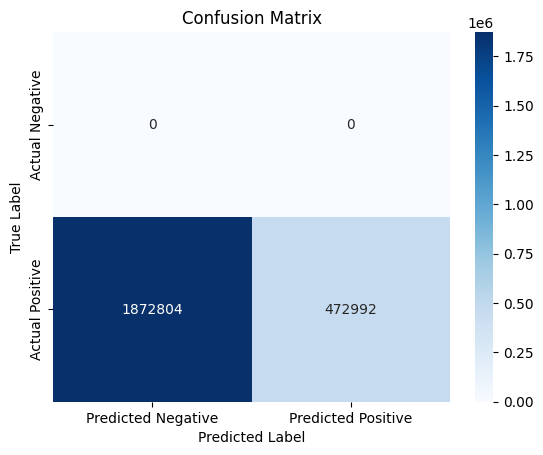

In [47]:
predictions = model.predict(x_test)
y_pred_binary = [1 if pred > 0.6 else 0 for pred in predictions]

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_binary, zero_division=1))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()